In [1]:
from asammdf import MDF
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [34]:
rootPath = r'C:\Users\YCAI40\OneDrive - Volvo Cars\case\energy_consumption\data_new\RWEC3.0\HPT2001\2021-09-04_Saturday_Low+High\RWEC_XC40_HPT2001_Part2_Low+High_20210904_1246-1553_T011.mdf'
data = MDF(rootPath,raise_on_multiple_occurrences=False)

dataFiltered = data.to_dataframe(['VehSpdLgtSafe','ALgt1','BkpOfDstTrvld',
                            'HvBattPwr','HvThermPwrCns','RoadIncln','VehM','HvHeatrPwrCns2','AmbTIndcd'],time_as_date=True)  

df = dataFiltered.rename(columns={'VehSpdLgtSafe':'speed',
                        'ALgt1':'acceleration',
                        'BkpOfDstTrvld':'total_driven_distance',
                        'HvBattPwr':'output_power',
                        'HvThermPwrCns':'thermal_system_power_consumption',
                        'RoadIncln':'inclination',
                        'VehM':'vehicle_mass',
                        'HvHeatrPwrCns2':'AC_consumption'})


df['speed(km/h)'] = df['speed'] * 3.6
df_second = df.resample('0.1S').mean().reset_index()
df_second.head()

,timestamps,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,AmbTIndcd,speed(km/h)
0,2021-08-31 20:22:51+08:00,0.0,0.0,13773.0,0.0,0.0,0.0,2310.0,0.0,21.0,0.0
1,2021-08-31 20:22:51.100000+08:00,0.0,0.0,13773.0,0.0,0.0,0.0,2310.0,0.0,21.0,0.0
2,2021-08-31 20:22:51.200000+08:00,0.0,0.0,13773.0,0.0,0.0,0.0,2310.0,0.0,21.0,0.0
3,2021-08-31 20:22:51.300000+08:00,0.0,0.0,13773.0,0.0,0.0,0.0,2310.0,0.0,21.0,0.0
4,2021-08-31 20:22:51.400000+08:00,0.0,0.0,13773.0,0.0,0.0,0.0,2310.0,0.0,21.0,0.0


In [35]:
# find all the stop time withint entire driving cycle
def findAllZero(df: pd.DataFrame,factor:str,time:str) -> pd.DataFrame:
    segments = []
    start = None
    for index,_ in df.iterrows():
        if df.loc[index,factor] == 0:
            if start is None:
                start = df.loc[index,time]
        else:
            if start is not None:
                segments.append([start,df.loc[index,time]])
                start = None
    if start is not None:
        segments.append([start,df.loc[len(df)-1,time]])
    stop = pd.DataFrame(columns=['start','end'],data = segments)
    return stop

# 找到所有的连续为0数据的时间段并计算连续停留的时间长度
stop = findAllZero(df_second,'speed(km/h)','timestamps')

stop['timeLength'] = [(row['end']-row['start']).total_seconds() for _,row in stop.iterrows()]
delete = stop.loc[stop['timeLength']>=200]
idling = stop.loc[stop['timeLength']<200]

In [36]:
def deleteZeroDf(df:pd.DataFrame,delete:pd.DataFrame)->pd.DataFrame:
    for index,_ in delete.iterrows():
        start = delete.loc[index,'start']
        end = delete.loc[index,'end']
        df = df[(df['timestamps'] < start) | (df['timestamps'] > end)]
    return df

df_200 = deleteZeroDf(df_second,delete)
df_200['label']='moving'

for i,r in idling.iterrows():
    label_i = (df_200['timestamps'] >= r['start']) & (df_200['timestamps'] <= r['end'])
    df_200.loc[label_i,'label']='idling'

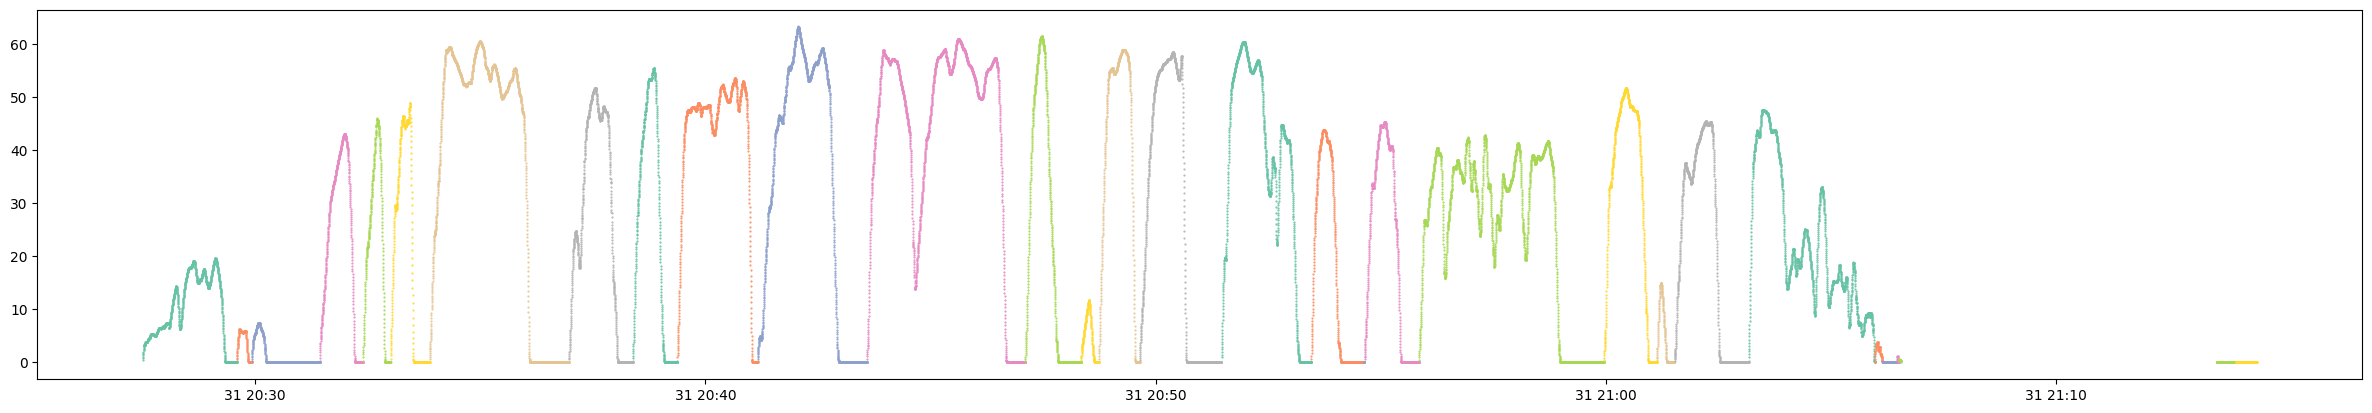

In [37]:
#create group id each changing phase as a stop
label_changes = df_200['label'].ne(df_200['label'].shift())
group_id = label_changes.cumsum()
df_200['group_id']=group_id
#generate cycle_id by combining a moving piece and idling piece
df_200['cycle_id']=(df_200['group_id']+1)//2


groupNum = df_200['group_id'].max()
color_labels = df_200['cycle_id'].unique()
rgb_values = sns.color_palette("Set2", groupNum)
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_figwidth(30)
Size = 0.3
for g in np.unique(df_200['cycle_id']):
    ix = np.where(df_200['cycle_id'] == g)

    ax.scatter(df_200['timestamps'].to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], color = color_map[g], label = g, s = Size)
plt.show()

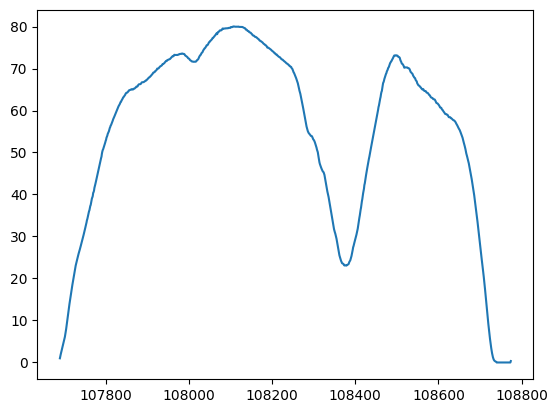

In [28]:
cycle_46 = df_200[df_200['cycle_id'] == 72]
plt.plot(cycle_46['speed(km/h)'])

In [29]:
df_200.to_csv('processedCSV/20210904_1246-1553_T011.csv')

### Create Driving Cycle feature

In [39]:
#generate cycle information
grouped = df_200.groupby('cycle_id')

idling_percentage = grouped.apply(lambda x: (x['label'] =='idling').mean()*100)
speed_avg = grouped['speed(km/h)'].mean()
speed_max = grouped['speed(km/h)'].max()
acceleration_max = grouped['acceleration'].max()
acceleration_min = grouped['acceleration'].min()
acceleration_avg = grouped['acceleration'].mean()
acceleration_std = grouped['acceleration'].std()
mileage = grouped['total_driven_distance'].max() - grouped['total_driven_distance'].min()
time = grouped['timestamps'].max() - grouped['timestamps'].min()
energy = grouped['output_power'].sum()

df_cycle = pd.DataFrame({
    'cycle_id':idling_percentage.index,
    'idling_percentage':idling_percentage.values,
    'average_speed':speed_avg.values,
    'max_speed':speed_max.values,
    'max_acc':acceleration_max.values,
    'min_acc':acceleration_min.values,
    'average_acc':acceleration_avg.values,
    'std_acc':acceleration_std.values,
    'mileage':mileage.values,
    'time':time.values,
    'energy':energy.values
})

In [40]:
# labeling cycle based on speed edge in CLTC: 60, 80
def speed_labels(speed):
    if (speed <60): return "low"
    if (speed >= 60) & (speed < 80): return "mid"
    else: return "high"



for index, item in df_cycle.iterrows():
    df_cycle.loc[index,'speed_label'] = speed_labels(df_cycle.loc[index,'max_speed'])
    print("\r",index,end = '')

df_cycle['cycle_id']=df_cycle['cycle_id'].astype('int64')
df_cycle

 29

,cycle_id,idling_percentage,average_speed,max_speed,max_acc,min_acc,average_acc,std_acc,mileage,time,energy,speed_label
0,1,12.150280,10.059308,19.621944,0.528298,-1.057324,-0.103405,0.281861,1.0,0 days 00:02:05,3689.940227,low
1,2,21.105528,3.686723,6.261195,0.559467,-0.702250,-0.100901,0.288951,0.0,0 days 00:00:19.800000,400.139571,low
2,3,78.524229,1.089973,7.488619,0.874458,-0.973326,-0.125382,0.140358,0.0,0 days 00:01:30.700000,1507.064687,low
3,4,18.260870,22.971337,43.086636,0.943279,-1.947130,-0.071351,0.615704,0.0,0 days 00:00:57.400000,3621.339900,low
4,5,19.398907,22.394195,46.000691,1.395067,-2.523068,-0.067131,0.963228,0.0,0 days 00:00:36.500000,2933.062103,low
5,6,40.917782,19.813344,48.969863,1.553496,-4.228546,-0.028183,1.106242,1.0,0 days 00:00:52.200000,4239.264902,low
6,7,28.056004,35.412923,60.512724,1.548387,-2.936036,-0.059599,0.481734,1.0,0 days 00:03:05.600000,12317.256874,mid
7,8,23.501763,25.785753,51.757446,1.309561,-1.851721,-0.070951,0.613780,1.0,0 days 00:01:25,4703.971655,low
8,9,28.716216,25.331827,55.466471,1.471193,-1.957020,-0.042161,0.781351,0.0,0 days 00:00:59.100000,4119.773445,low
9,10,6.448598,41.739355,53.629560,1.698809,-3.092536,-0.056378,0.696301,2.0,0 days 00:01:46.900000,8230.605139,low


In [32]:
df_cycle[df_cycle['speed_label'] =='high']

,cycle_id,idling_percentage,average_speed,max_speed,max_acc,min_acc,average_acc,std_acc,mileage,time,energy,speed_label
46,47,0.128015,89.971197,134.130204,1.745184,-2.675618,-0.058901,0.385404,48.0,0 days 00:32:32.800000,370382.256618,high
52,53,1.380884,87.009152,129.625884,2.074499,-5.575882,-0.068505,0.580224,19.0,0 days 00:19:09.500000,143612.019449,high
64,65,22.869955,40.389859,83.990599,2.997308,-3.129080,-0.064959,1.155962,1.0,0 days 00:01:06.800000,5835.670205,high
66,67,0.558252,40.917051,82.330524,2.774694,-2.750227,-0.064976,0.830370,5.0,0 days 00:06:51.900000,27269.521730,high
71,72,3.225806,55.216036,80.007984,2.109704,-3.292428,-0.061170,0.951204,2.0,0 days 00:01:48.400000,10294.232390,high


In [41]:
df_cycle.to_csv('cycleData/20210831_1223-1314_Mid_T006.csv')

In [51]:
df_200.to_csv('processedCSV/20210901_High_T005.csv')

In [54]:
df_200.describe()

,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,AmbTIndcd,speed(km/h),group_id,cycle_id
count,100507.000000,100507.000000,100507.000000,100507.000000,100507.000000,100507.000000,100507.000000,100507.0,100507.000000,100507.000000,102719.000000,102719.000000
mean,11.717112,-0.067193,14197.693234,8.589554,1621.810630,0.006495,2382.122277,0.0,30.717275,42.181604,78.526280,38.865974
std,10.197600,0.596939,59.697000,19.070671,787.344864,0.009863,17.000906,0.0,7.044105,36.711361,36.555101,18.258697
min,0.000000,-5.575882,0.000000,-96.603381,0.000000,-0.057029,2310.000000,0.0,-100.000000,0.000000,1.000000,0.000000
25%,1.139497,-0.302289,14163.000000,0.250000,1080.000000,0.001163,2370.000000,0.0,30.000000,4.102188,51.000000,25.000000
50%,10.714077,-0.082283,14184.000000,2.250000,1300.000000,0.005598,2379.000000,0.0,31.000000,38.570678,84.000000,42.000000
75%,18.316749,0.138483,14234.000000,14.949874,2340.000000,0.010756,2394.000000,0.0,32.000000,65.940295,101.000000,50.000000
max,37.258390,2.997308,14265.000000,124.180096,4140.000000,0.060725,2425.000000,0.0,36.000000,134.130204,156.000000,78.000000


C:\Users\YCAI40\AppData\Local\Temp\ipykernel_50680\741842186.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)


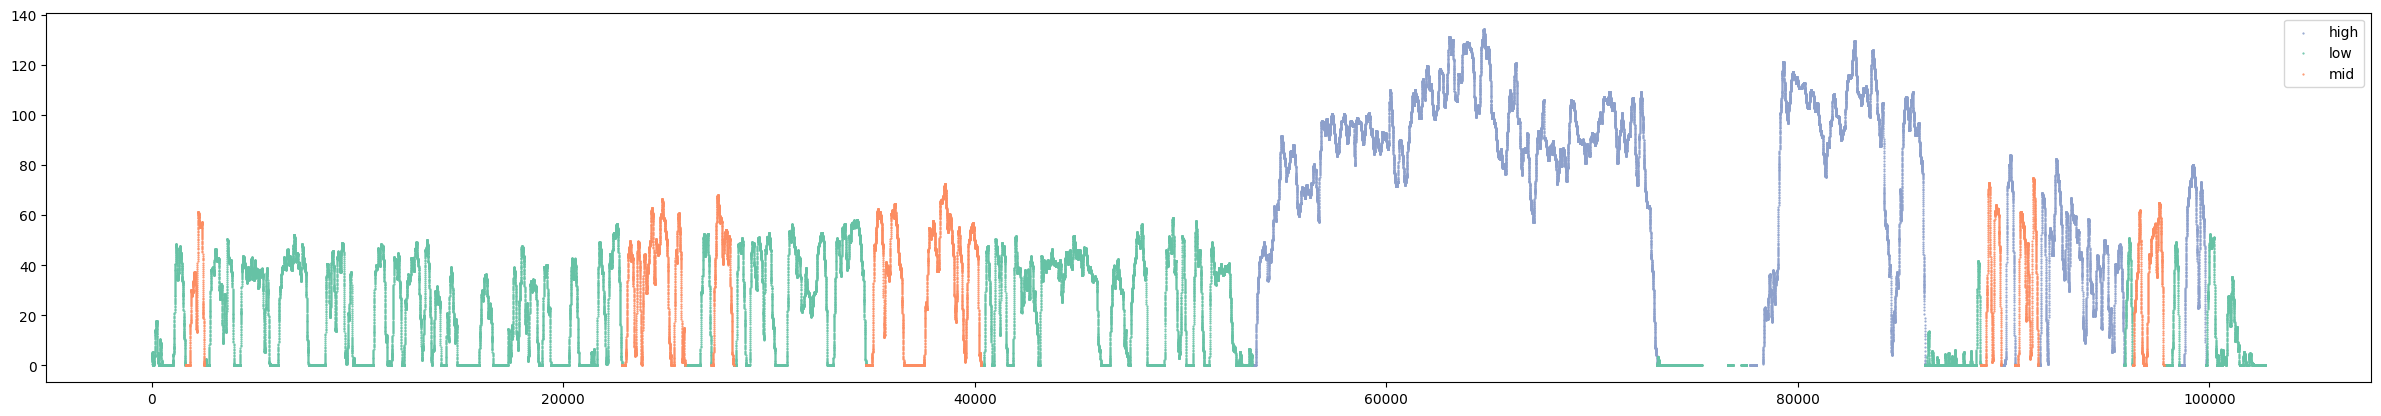

In [52]:
df_200 = df_200.merge(df_cycle[['cycle_id','speed_label']], on='cycle_id',how='left')

#plot low, mid, high based on speed label
color_labels = df_200['speed_label'].unique()
rgb_values = sns.color_palette("Set2", 3)
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_figwidth(30)
Size = 0.3
for g in np.unique(df_200['speed_label']):
    ix = np.where(df_200['speed_label'] == g)

    ax.scatter(df_200.index.to_numpy()[ix], df_200['speed(km/h)'].to_numpy()[ix], c = color_map[g], label = g, s = Size)
ax.legend()
plt.show()

In [1]:
import plotly.express as px


In [10]:
import pandas as pd
df_200 = pd.read_csv('processedCSV/20210904_1246-1553_T011.csv',index_col=0,parse_dates=[1])


In [12]:
df_200

,timestamps,speed,acceleration,total_driven_distance,output_power,thermal_system_power_consumption,inclination,vehicle_mass,AC_consumption,AmbTIndcd,speed(km/h),label,group_id,cycle_id
5746,2021-09-04 20:56:31.800000+08:00,0.216476,0.776876,14149.0,3.970705,1740.0,-0.003908,2310.0,0.0,36.0,0.779315,moving,1,0
5747,2021-09-04 20:56:31.900000+08:00,0.357076,0.635840,14149.0,3.761693,1740.0,-0.004318,2310.0,0.0,36.0,1.285474,moving,1,0
5748,2021-09-04 20:56:32+08:00,0.454209,0.503108,14149.0,3.750000,1740.0,-0.003940,2310.0,0.0,36.0,1.635151,moving,1,0
5749,2021-09-04 20:56:32.100000+08:00,0.511433,0.538403,14149.0,3.830454,1740.0,-0.002867,2310.0,0.0,36.0,1.841160,moving,1,0
5750,2021-09-04 20:56:32.200000+08:00,0.570845,0.534589,14149.0,4.000000,1740.0,-0.001452,2310.0,0.0,36.0,2.055042,moving,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111628,2021-09-04 23:53:00+08:00,0.000000,-0.017000,14265.0,1.000000,800.0,0.002431,2405.0,0.0,30.0,0.000000,idling,156,78
111629,2021-09-04 23:53:00.100000+08:00,0.000000,-0.017000,14265.0,1.000000,800.0,0.002441,2405.0,0.0,30.0,0.000000,idling,156,78
111630,2021-09-04 23:53:00.200000+08:00,0.000000,-0.017000,14265.0,1.000000,800.0,0.002441,2405.0,0.0,30.0,0.000000,idling,156,78
111631,2021-09-04 23:53:00.300000+08:00,0.000000,-0.017000,14265.0,1.000000,800.0,0.002462,2405.0,0.0,30.0,0.000000,idling,156,78


In [23]:
df_200['timestamps'] = [time[:-6] for time in df_200['timestamps']]

In [27]:
df_200['timestamps'] = pd.to_datetime(df_200['timestamps'],format='mixed')

In [28]:
df_200.dtypes

timestamps                          datetime64[ns]
speed                                      float64
acceleration                               float64
total_driven_distance                      float64
output_power                               float64
thermal_system_power_consumption           float64
inclination                                float64
vehicle_mass                               float64
AC_consumption                             float64
AmbTIndcd                                  float64
speed(km/h)                                float64
label                                       object
group_id                                     int64
cycle_id                                     int64
dtype: object